#### Importing Dataset

In [1]:
import numpy as np
import pandas as pd

from preprocessing.ImputeMean import ImputeMean
from preprocessing.TrainTestSplit import TrainTestSplit
from preprocessing.ZeroSales import ZeroSales
from preprocessing.DataAggregator import DataAggregator

from feature_engineering.Lag import Lag
from feature_engineering.Log import Log

from train_optimize_forecast.TrainModel import TrainModel
from train_optimize_forecast.HP_Tuning import SarimaxHyperopt

calendar_df = pd.read_csv('E:/Documents/TanXor/Dataset/calendar.csv')
sales_df = pd.read_csv('E:/Documents/TanXor/Dataset/sales_train_validation.csv')

#### Data Transformation

In [2]:
date = calendar_df['date'].iloc[:1913]
col1 = 'store_id'
col2 = 'dept_id'
data = sales_df

aggreg = DataAggregator(data, col1, col2, date)
sales = aggreg.aggregate()
sales = aggreg.transform()

zero_neg = ZeroSales(sales).zero_sales()
ImputeMean(sales, 0).imputer()
train_data, test_data = TrainTestSplit(sales, 0.2).data_split()
train_data.index.freq = test_data.index.freq = 'd'

### Feature Engineering

In [4]:
seasonal_lag = Lag(train_data).lag_transform(7, train_data.columns[2])
#train_data = Log(train_data).log_transform(train_data.columns[0])

In [5]:
seasonal_lag['diff'] = seasonal_lag[seasonal_lag.columns[0]] - seasonal_lag[seasonal_lag.columns[1]].dropna()
seasonal_lag = seasonal_lag.dropna()

### Stationarity Test

In [6]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [7]:
def adfuller_test(data):
    result=adfuller(data)
    return result[1]

In [8]:
print(adfuller_test(train_data[train_data.columns[2]]))

0.1015253121077393


In [9]:
print(adfuller_test(seasonal_lag[seasonal_lag.columns[-1]]))

4.911582649993136e-30


In [10]:
for i in train_data.columns[:70]:
    if (adfuller_test(train_data[i]) <= 0.05):
        print(i, "Pass")
    else:
        print(i, "Fail")

CA_1_FOODS_1 Pass
CA_1_FOODS_2 Pass
CA_1_FOODS_3 Fail
CA_1_HOBBIES_1 Pass
CA_1_HOBBIES_2 Pass
CA_1_HOUSEHOLD_1 Fail
CA_1_HOUSEHOLD_2 Fail
CA_2_FOODS_1 Pass
CA_2_FOODS_2 Pass
CA_2_FOODS_3 Fail
CA_2_HOBBIES_1 Pass
CA_2_HOBBIES_2 Pass
CA_2_HOUSEHOLD_1 Fail
CA_2_HOUSEHOLD_2 Fail
CA_3_FOODS_1 Pass
CA_3_FOODS_2 Pass
CA_3_FOODS_3 Fail
CA_3_HOBBIES_1 Fail
CA_3_HOBBIES_2 Pass
CA_3_HOUSEHOLD_1 Fail
CA_3_HOUSEHOLD_2 Fail
CA_4_FOODS_1 Pass
CA_4_FOODS_2 Pass
CA_4_FOODS_3 Fail
CA_4_HOBBIES_1 Fail
CA_4_HOBBIES_2 Pass
CA_4_HOUSEHOLD_1 Fail
CA_4_HOUSEHOLD_2 Fail
TX_1_FOODS_1 Fail
TX_1_FOODS_2 Pass
TX_1_FOODS_3 Pass
TX_1_HOBBIES_1 Fail
TX_1_HOBBIES_2 Pass
TX_1_HOUSEHOLD_1 Fail
TX_1_HOUSEHOLD_2 Fail
TX_2_FOODS_1 Fail
TX_2_FOODS_2 Pass
TX_2_FOODS_3 Fail
TX_2_HOBBIES_1 Fail
TX_2_HOBBIES_2 Pass
TX_2_HOUSEHOLD_1 Fail
TX_2_HOUSEHOLD_2 Pass
TX_3_FOODS_1 Fail
TX_3_FOODS_2 Pass
TX_3_FOODS_3 Pass
TX_3_HOBBIES_1 Fail
TX_3_HOBBIES_2 Pass
TX_3_HOUSEHOLD_1 Fail
TX_3_HOUSEHOLD_2 Fail
WI_1_FOODS_1 Pass
WI_1_FOODS_2 Fai

### Model Training

In [11]:
params = {
    'p': 1,
    'd': 1,
    'q': 4,
    'P': 2,
    'D': 1,
    'Q': 3,
    's': 7
}

In [12]:
model = TrainModel(train_data[train_data.columns[0]])
model_fit = model.train(params)

KeyboardInterrupt: 

<AxesSubplot:>

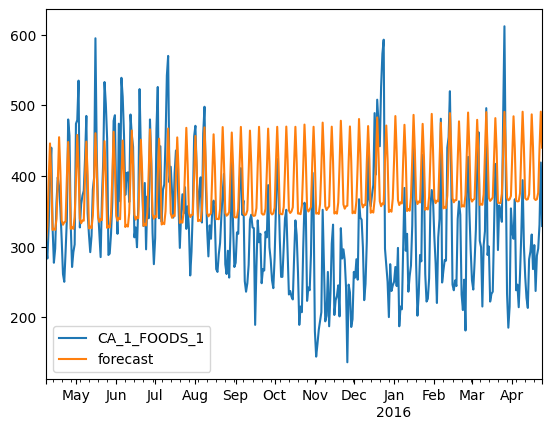

In [ ]:
col = test_data.columns[0]
test_data['forecast']=model_fit.forecast(steps=test_data[col].shape[0])
test_data[[col, 'forecast']].plot()

In [ ]:
mape = np.mean(np.abs((test_data[col] - test_data['forecast']) / test_data[col])) * 100
mape

29.707111202128054

# Tuning

In [ ]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
import statsmodels.api as sm

space = {
    'p': hp.choice('p', range(0, 3)),
    'd': hp.choice('d', range(0, 3)),
    'q': hp.choice('q', range(0, 3)),
    'P': hp.choice('P', range(0, 3)),
    'D': hp.choice('D', range(0, 3)),
    'Q': hp.choice('Q', range(0, 3)),
    's': hp.choice('s', [7]),
}

def objective(space):
    sarimax_model=sm.tsa.statespace.SARIMAX(train_data[train_data.columns[0]],
                                            order=(space['p'], space['d'], space['q']),
                                            seasonal_order=(space['P'], space['D'], space['Q'], space['s']),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
    sarimax_result = sarimax_model.fit(maxiter = 500)
    y_pred = sarimax_result.forecast(steps=test_data.shape[0])
    mape = np.mean(np.abs((test_data[test_data.columns[0]] - y_pred) / test_data[test_data.columns[0]])) * 100

    return {'loss': mape, 'status': STATUS_OK }

trials = Trials()
best = fmin(fn= objective, space= space, algo= tpe.suggest, max_evals = 50, trials= trials)

In [3]:
hp_model = SarimaxHyperopt(train_data[train_data.columns[0]], test_data[test_data.columns[0]])

Test data shape:  (383,)


In [4]:

hp_model.hyperparameter_tune(num_evals=3)

  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 33%|███▎      | 1/3 [00:10<00:20, 10.45s/trial, best loss: 28.75123265784562]

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 67%|██████▋   | 2/3 [00:22<00:11, 11.41s/trial, best loss: 28.75123265784562]

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



100%|██████████| 3/3 [00:50<00:00, 16.70s/trial, best loss: 28.75123265784562]


In [ ]:
hp_model.fit()

In [11]:
hp_model.predict()

AttributeError: 'Series' object has no attribute 'predicted_mean'

### Hyperparamter Tuning

In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

# Ignore ValueWarning from statsmodels
warnings.simplefilter('ignore', ValueWarning)

In [ ]:
### Import Packages ###
'''
import itertools

### Define Parameter Ranges to Test ###

# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = range(1, 6)
q = range(0, 6)
d = range(1, 2)
P = range(0, 4)
Q = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(P, d, Q))]

### Run Grid Search ###

# Note: this code will take a while to run

# Define function
def sarimax_gridsearch(ts, pdq, pdqs, freq='D'):
    
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False, 
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(maxiter=1000)
                predictions = output.predict(start=1800,end=1913,dynamic=True)

                test_data = ts.iloc[1800:1913]
                mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

                ans.append([comb, combs, output.bic, mape])
                print('SARIMAX {} x {}12 : MAPE Calculated ={}'.format(comb, combs, mape))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic', 'mape'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['mape'],ascending=True)
    
    return ans_df
    
'''

In [ ]:
### Apply function to your time series data ###

# Remember to change frequency to match your time series data
# best_params = sarimax_gridsearch(df_1['Sales'], pdq, pdqs, freq='D')

In [ ]:
# best_params.head(20)

In [ ]:
# Build SARIMAX model w/optimal parameters
sarimax=SARIMAX(df_1['Sales'],
                order=(3,1,3), 
                seasonal_order=(0,1,1,7), 
                enforce_stationarity=False, 
                enforce_invertibility=False,
                freq='D')
                                    
# Fit the model
output = sarimax.fit()
    
# Print output summary
#print(output.summary())

# Plot diagnostics
#output.plot_diagnostics(figsize=(16,10));

In [ ]:
df_1['forecast']=output.predict(start=1800,end=1913,dynamic=True)
df_1[['Sales','forecast']].iloc[1800:].plot()

In [ ]:
%pip install optuna

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
#from sklearn import datasets

def objective(trial):
    p = trial.suggest_int('p', 0, 6)
    # d = trial.suggest_int('d', 1, 3)
    q = trial.suggest_int('q', 0, 6)
    P = trial.suggest_int('P', 0, 6)
    Q = trial.suggest_int('Q', 0, 6)
    # m = trial.suggest_int('m', 3, 8)
    srx = sm.tsa.statespace.SARIMAX(df_1['Sales'], 
                                    order=(p,1,q), 
                                    seasonal_order=(P,1,Q,7), 
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False,
                                    freq='D')
    
    output = srx.fit(maxiter=1000)
    predictions = output.predict(start=1800,end=1913,dynamic=True)

    test_data = df_1['Sales'].iloc[1800:1913]
    mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

    return mape

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

In [ ]:
trial = study.best_trial
print('Mape: {}'.format(trial.value))

In [ ]:
print("Best hyperparameters: {}".format(trial.params))